# Wavelet Analysis 

We want to answer the questions whether there is more goal scoring, more goal efficiency, more hits, more penalty minutes per hits towards the end of the regular season. To this end we employ a statistical method to analyze data series, which allows a time shifting view into the spectrum of a time series. Whereas methods such as Fourier decomposition of time series and power spectral analysis of the resulting modes reveal only a time averaged picture, the wavelet analysis opens the perspective of an in depth view into the changing frequency patterns of a signal. 

In [1]:
# load libraries for global use
library(ggplot2)
library(WaveletComp)
DATACAPTIONVEC <- c("ID","SEASON","DATE","TEAM1","TEAM2","WON","SCORE","SHOTS","FACEOFF","TAKEAWAY","GIVEAWAY","PIM","HITS","PPG","ATTENDANCE")
MYTEAM="NYI"


Attaching package: ‘WaveletComp’

The following object is masked from ‘package:ggplot2’:

    arrow



In the next step we read the input data as generated by the python class dataMiner.py. The input data consists of data with postfix Delta and Sum, with Sum data defined as $X_{\Delta}=X_{h}-X_{a}$ with $X_{h,a} \in X \in \mathbb{D}^{d}$ and $X_{\Sigma}=X_{h}+X_{a}$ with $X_{h,a} \in \mathbb{D}^{d}$ ($\mathbb{D}$ a mixture of binary and natural numbers), d dimensional home and away team statistics vectors. In our case every datasample has 16 entries,with 10 numerical attributes per dataset, giving d=10. The first 6 attributes of each dataset like season, game id and teams who played contain supplementery information and are important only in the preprocessing process. We may write our dataset as "set" $X_{\Delta,Sum} = F ( x_{won},x_{score},x_{shots},x_{faceoff},x_{takeaway},x_{giveaway},x_{pim},x_{hits},x_{ppg},x_{attendance} )$ with F a function of the datasets for home and away teams, as described above. $x_{won}$ takes binary values $x_{won} \in [0,1]$, 0 for loss and 1 for game won. The other attributes take integer values.

In [2]:
#read summed and delta NHL data
#from datasets created using python
nhlDataSum=data.frame()
nhlDataDelta=data.frame()
#SeasonVector=c(2010,2011,2012,2014,2015,2016)
SeasonVector=c(2014,2015)
NumberOfSeasons=length(SeasonVector)
for(season in SeasonVector)
{
  tableName=paste("../dataSetsNHL/dataFileNhl_",season,"_regular_sum.dat",sep="")
  nhlDataS=read.table(tableName)
  colnames(nhlDataS) <- DATACAPTIONVEC
  nhlDataSum<-rbind(nhlDataSum,nhlDataS)
  tableName=paste("../dataSetsNHL/dataFileNhl_",season,"_regular_delta.dat",sep="")
  nhlDataS=read.table(tableName)
  colnames(nhlDataS) <- DATACAPTIONVEC
  nhlDataDelta<-rbind(nhlDataDelta,nhlDataS)
}
colnames(nhlDataSum) <- DATACAPTIONVEC
colnames(nhlDataDelta) <- DATACAPTIONVEC
print(paste(nrow(nhlDataSum),ncol(nhlDataSum)))

[1] "2378 15"


Now we calculate some additional statistics by combining the input data. We compute the shooting accuracy $F_{sac}={Shots \over Goals}$, a strictness indicator by dividing the overall penalty minutes through the hits taken $F_{strict}={Hits \over Penalty minutes}$ and the effectiveness of the powerplay: $F_{pplay}={Powerplay goals \over Penalty minutes}$.

In [3]:
Fsac=nhlDataSum$SHOTS/nhlDataSum$SCORE
Fstrict=nhlDataSum$HITS/nhlDataSum$PIM
Fpplay=nhlDataSum$PPG/nhlDataSum$PIM
print(paste(length(Fpplay),is.vector(Fpplay)))

[1] "2378 TRUE"


Check for Nan and replace by zeros.

In [4]:
Fsac[is.na(Fsac)] <- 0
Fstrict[is.na(Fstrict)] <- 0
Fpplay[is.na(Fpplay)] <- 0

Now we add the data to the summed dataset.

In [5]:
print(paste(nrow(nhlDataSum),ncol(nhlDataSum)))
nhlDataSumAdd=cbind(nhlDataSum,Fsac,Fstrict,Fpplay)
DATACAPTIONVECWITHADD <- c("ID","SEASON","DATE","TEAM1","TEAM2","WON","SCORE","SHOTS","FACEOFF","TAKEAWAY","GIVEAWAY","PIM","HITS","PPG","ATTENDANCE","FSAC","FSTRICT","FPPLAY")
colnames(nhlDataSumAdd) <- DATACAPTIONVECWITHADD
print(paste(nrow(nhlDataSumAdd),ncol(nhlDataSumAdd)))

[1] "2378 15"
[1] "2378 18"


Now we have the input data for regular NHL seasons between 2010 and 2016 in one data frame. We have assigned meaningful captions to adress the data columns. What we want to do next is to get game day data to analyze how these cumulative statis change in time. We sum up all the statistics in one gameday for the delta and summed datasets. The function extractGamesPerDayStatistics will do the job. It's core functionality is to loop over each date in the input data and agglomerate the statistics into one row of the output dataset.

In [6]:
extractGamesPerDayStatistics <- function(thisSeason,fullData)
{
    #extract games from full season data.frame
    #sum up the statistics for one gameday and return the condensed dataset

    # input: 
    #      thisSeason...number for season to do the analysis
    #      fullData ... dataframe containing input data
    # output:
    #      returnDataFrame ... dataframe with numberOfGameDays x numberOfSeasons entries
  stopifnot(!missing(thisSeason))
  stopifnot(!missing(fullData))  
  stopifnot(is.data.frame(fullData))
  stopifnot(is.numeric(thisSeason))

  dateVector=fullData$DATE
  dateVectorUnique=unique(dateVector)
    #initialize new data containers
  returnTmpDataFrame=data.frame()
  returnDataFrame=data.frame()
  currentId <- 0
  dateVec=c() 
  thisSeasonVec=c()
  gameDayIdVec=c()
    #loop over all games per date
  for (currentDate in dateVectorUnique)
  {
    #now filter for data for the specific date and season
    gamesOfThisDate <- subset(subset(fullData, SEASON==thisSeason), DATE==currentDate)
    #"games of this date"
    colIsNumericVector <- sapply(gamesOfThisDate, is.numeric)
    #number of games at this date
    numberOfGamesThisDay <- nrow(gamesOfThisDate)
    #now sum the game statistics up
    sumGamesOfThisDate <- colSums(gamesOfThisDate[,colIsNumericVector==TRUE],na.rm=FALSE)/numberOfGamesThisDay
    #now attach these values to a new data container
    currentId <- currentId + 1
    dateVec<-append(dateVec,currentDate)
    thisSeasonVec<-append(thisSeasonVec,thisSeason)
    gameDayIdVec<-append(gameDayIdVec,currentId)
    returnTmpDataFrame <- rbind(returnTmpDataFrame,sumGamesOfThisDate)
  }
  #now add the cols which were not numeric
  returnDataFrame=cbind(gameDayIdVec,thisSeasonVec,dateVec,"allTeams","allTeams",returnTmpDataFrame[4:16])
  return(returnDataFrame)
}

Now we apply this function to the overall sum data by looping over all the seasons available in the input.

In [7]:
gamesPerDaySum=data.frame()
for(season in SeasonVector)
{
    gamesPerDayPerSeason <- extractGamesPerDayStatistics(season,nhlDataSumAdd)
    print(paste(nrow(gamesPerDayPerSeason),ncol(gamesPerDayPerSeason)))
    colnames(gamesPerDayPerSeason) <- DATACAPTIONVECWITHADD
    gamesPerDaySum <- rbind(gamesPerDaySum,gamesPerDayPerSeason)
}
#assign the captions
#colnames(gamesPerDaySum) <- DATACAPTIONVECWITHADD

[1] "192 18"
[1] "192 18"


Let's plot the number of hits per gameday for the different seasons.

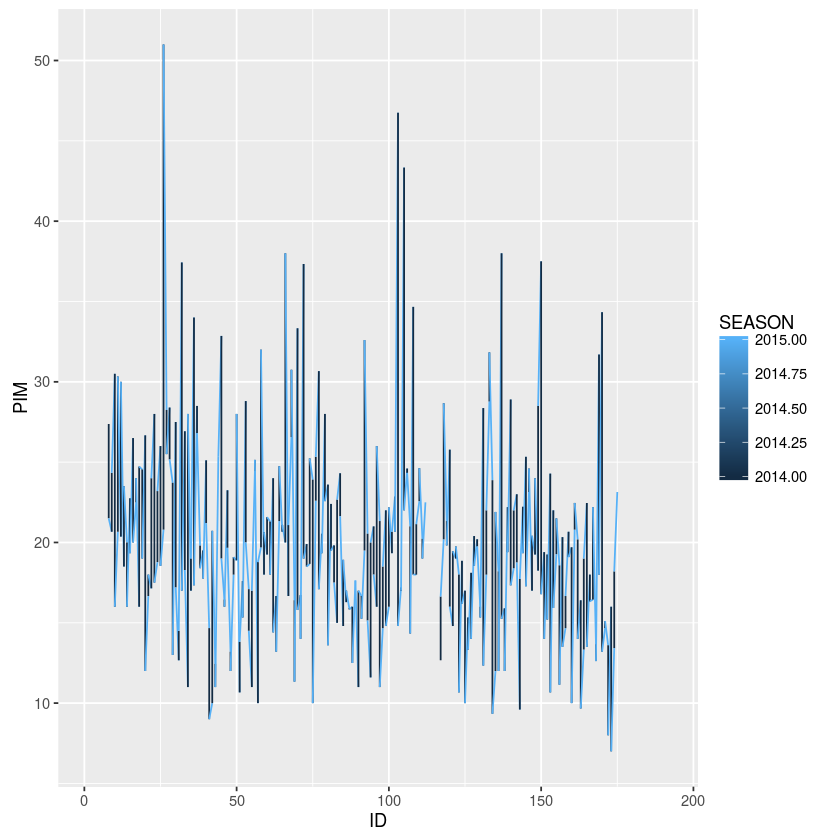

In [8]:
ggplot(data=gamesPerDaySum,aes(x=ID, y=PIM, colour=SEASON)) + geom_line()

Prepare data from my home team, the islanders. The datavectors $X_{Sum},X_{\Delta}$ are now combined to give the teams statistics. For home games we can simply add the two $X_{team,h}={1 \over 2} \{ X_{Sum} + X_{\Delta} \}$, for the away team stats we have to invert $X_{\Delta}$: $X_{team,a}={1 \over 2} \{ X_{Sum} - X_{\Delta} \}$, and finally add the two: $X_{team}=X_{team,h}+X_{team,a}$ to obtain the overall game stats. We are doing this for all the teams contained in the statistics, which are the following:

In [9]:
getTeamGameStatistics <- function(thisTeam)
    {
    matchS<-subset(nhlDataSum,nhlDataSum$TEAM1==thisTeam | nhlDataSum$TEAM2==thisTeam)
    matchH<-subset(nhlDataDelta,nhlDataDelta$TEAM1==thisTeam)
    matchA<-subset(nhlDataDelta,nhlDataDelta$TEAM2==thisTeam)
    
    #invert away data
    matchA$SCORE=-matchA$SCORE
    matchA$SHOTS=-matchA$SHOTS
    matchA$FACEOFF=-matchA$FACEOFF
    matchA$TAKEAWAY=-matchA$TAKEAWAY
    matchA$GIVEAWAY=-matchA$GIVEAWAY
    matchA$PIM=-matchA$PIM
    matchA$HITS=-matchA$HITS
    matchA$PPG=-matchA$PPG

    #add delta data
    matchD<-rbind(matchH,matchA)
    #now order for data then season
    tmp<-matchD[order(matchD$DATE),]
    matchDOrdered<-tmp[order(tmp$SEASON),]

    #compute the NYI values by combining delta and summed data
    teamData=0.5*(matchDOrdered[,sapply(matchDOrdered,is.numeric)]+matchS[,sapply(matchS,is.numeric)])
    return(teamData)
    }

In [10]:
matchNYI <- getTeamGameStatistics(MYTEAM)

As an example we plot the goals scored per game by the Islanders in the games over the seasons.

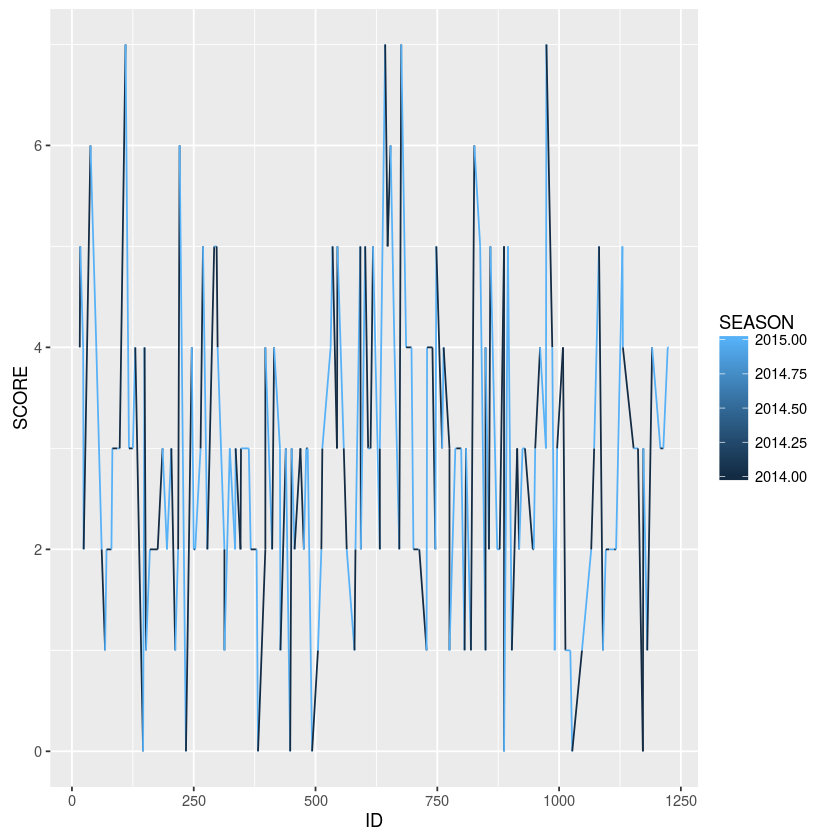

In [11]:

ggplot(data=matchNYI,aes(x=ID, y=SCORE, colour=SEASON)) + geom_line()


The plot is not very conclusive, indicating a high frequency behaviour over the whole range. Using the package WaveletComp we examine the structure more closely to see if there are hiding patterns. To do the wavelet analysis we use the R package "WaveletComp", which allows us to do nice plotting also. A wavelet analysis uses a wavelet, kind of a window function, which is shifted all over the dataset and the size of which is changed in the process. The modes we see below are integrals of the data over this wavelet window function, which has a finite support.

In [49]:
waveletAnalysis <- function(dataFrame,category,season,minWidth,maxWidth,caption)
{
    #do the wavelet analysis
    #Arguments:
    # dataFrame - input dataset
    # category - which category to analyze in the dataframe
    # season - the season to analyze for
    # minWidth - the minimal width of the wavelet
    # maxWidth - the maximal width of the wavelet
    # caption - plot caption
        thisSeasonData <- dataFrame[which(dataFrame$SEASON %in% season),]
        #we scale the data from 0 to 1 
        Xscore <- scale(thisSeasonData[,eval(quote(category))])
        Xscore[is.na(Xscore)] <- 0
        my.data = data.frame(x=Xscore)
        my.w = analyze.wavelet(my.data, "x",
                               loess.span = 0,
                               dt = 1, dj = 1/250,
                               lowerPeriod = minWidth,
                               upperPeriod = maxWidth,
                               make.pval = T, n.sim = 10)
        titleMessage <- paste(caption," - season ",season,sep="")
        wt.image(my.w,main=titleMessage, color.key = "quantile", n.levels = 250,legend.params = list(lab = "wavelet power levels", mar = 4.7))
        axis(side = 1,at=c(length(Xscore)/2))
}

Starting wavelet transformation...
... and simulations... 
  |======================================================================| 100%
Class attributes are accessible through following names:
series loess.span dt dj Wave Phase Ampl Power Power.avg Power.pval Power.avg.pval Ridge Period Scale nc nr coi.1 coi.2 axis.1 axis.2 


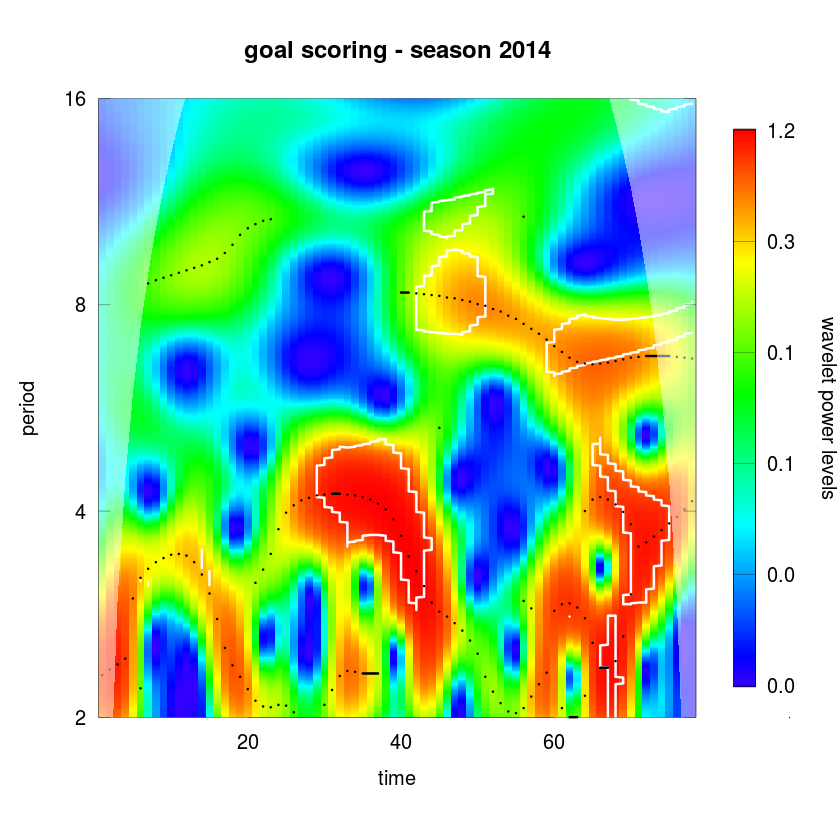

In [50]:
waveletAnalysis(matchNYI,"SCORE",2014,2,16,"goal scoring")

In the season 2014 we see an elevated scoring activity of the Islanders around game 60 to 70. Even the period 8 of the wavelet components around 60-70 are eleveated, indicating that the goal scoring machinery was working well for the Islanders around the end of the season. Also in the first few games of the season the goal scoring was above average. A slight slump around game 25 is visible, which was also present around game 50. Let's inspect the 2015 season.

Starting wavelet transformation...
... and simulations... 
  |======================================================================| 100%
Class attributes are accessible through following names:
series loess.span dt dj Wave Phase Ampl Power Power.avg Power.pval Power.avg.pval Ridge Period Scale nc nr coi.1 coi.2 axis.1 axis.2 


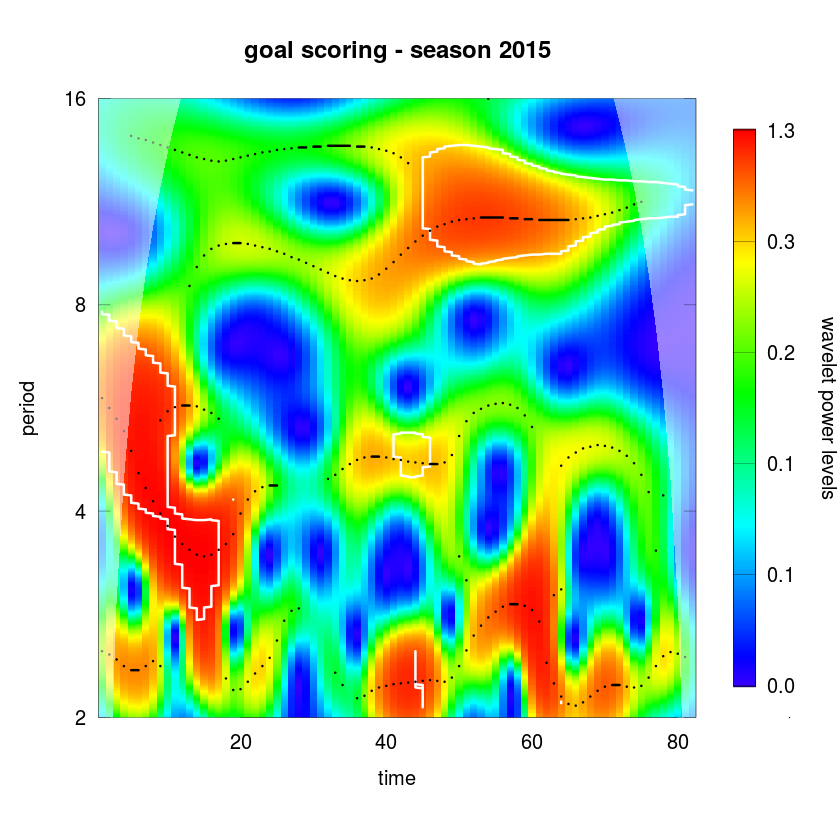

In [51]:
waveletAnalysis(matchNYI,"SCORE",2015,2,16,"goal scoring")

There seems to have been a bit of a scoring slump at the end of the season, but again a strong start is indicated by the elevated mode amplitude for the wavelet components around 2 and 8 between game 1 and 20. One has to be careful in interpreting the boundary values of the amplitude plot, as boundary conditions play a role there. Let's now look at the overall  league scoring in 2015. We increase the maximal size of the wavelet window with from 16 to 32 and analyze the agglomerated sum data.

Starting wavelet transformation...
... and simulations... 
  |======================================================================| 100%
Class attributes are accessible through following names:
series loess.span dt dj Wave Phase Ampl Power Power.avg Power.pval Power.avg.pval Ridge Period Scale nc nr coi.1 coi.2 axis.1 axis.2 


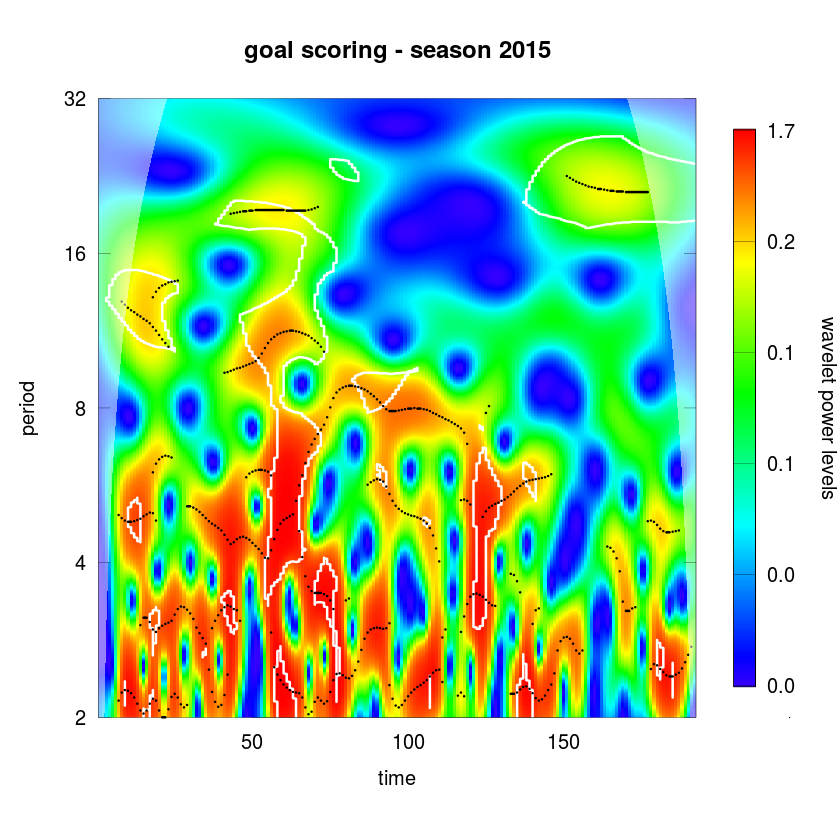

In [52]:
waveletAnalysis(gamesPerDaySum,"SCORE",2015,2,32,"goal scoring")

The picture is intermittent, but one can see a certain tendency to lesser goals towards the end of the season. Did the players get tired or the goalies even better? Now let's see the combined statistics we evaluated before. The shooting accuracy $F_{sac}={Shots \over Goals}$, a strictness indicator by dividing the overall penalty minutes through the hits taken $F_{strict}={Hits \over Penalty minutes}$ and the effectiveness of the powerplay scoring $F_{pplay}={Powerplay goals \over Penalty minutes}$. we now analyze the wavelet decomposition over seasons 2014 and 2015 of these 

Starting wavelet transformation...
... and simulations... 
  |======================================================================| 100%
Class attributes are accessible through following names:
series loess.span dt dj Wave Phase Ampl Power Power.avg Power.pval Power.avg.pval Ridge Period Scale nc nr coi.1 coi.2 axis.1 axis.2 


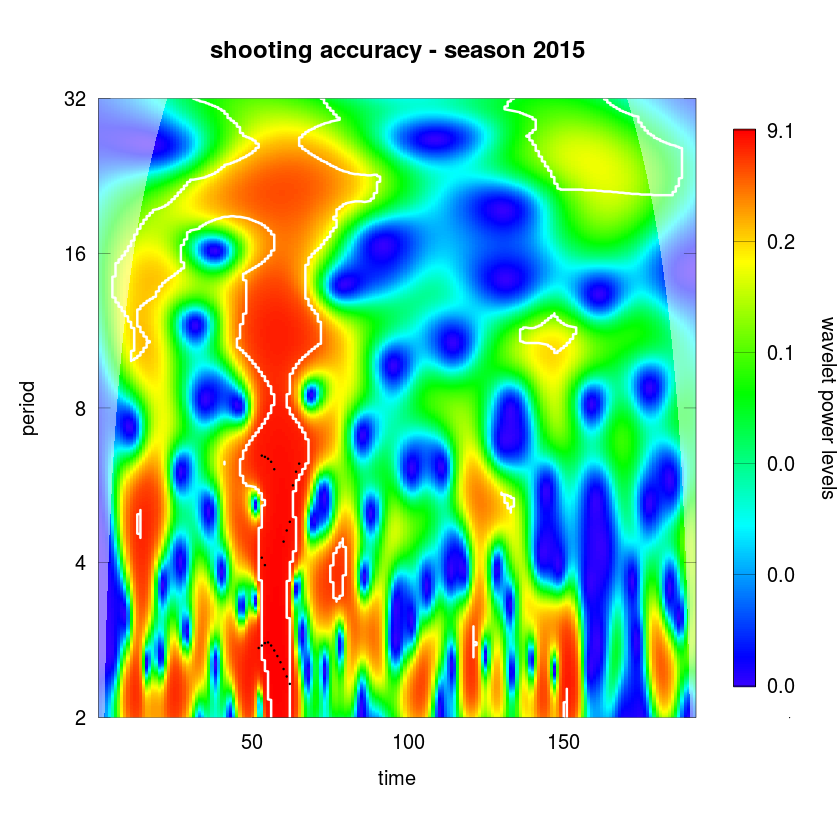

In [53]:
waveletAnalysis(gamesPerDaySum,"FSAC",2015,2,32,"shooting accuracy")

There was one day around game day 55, where there was a maximum in shooting accuracy. If we compare this with season 2014.

Starting wavelet transformation...
... and simulations... 
  |======================================================================| 100%
Class attributes are accessible through following names:
series loess.span dt dj Wave Phase Ampl Power Power.avg Power.pval Power.avg.pval Ridge Period Scale nc nr coi.1 coi.2 axis.1 axis.2 


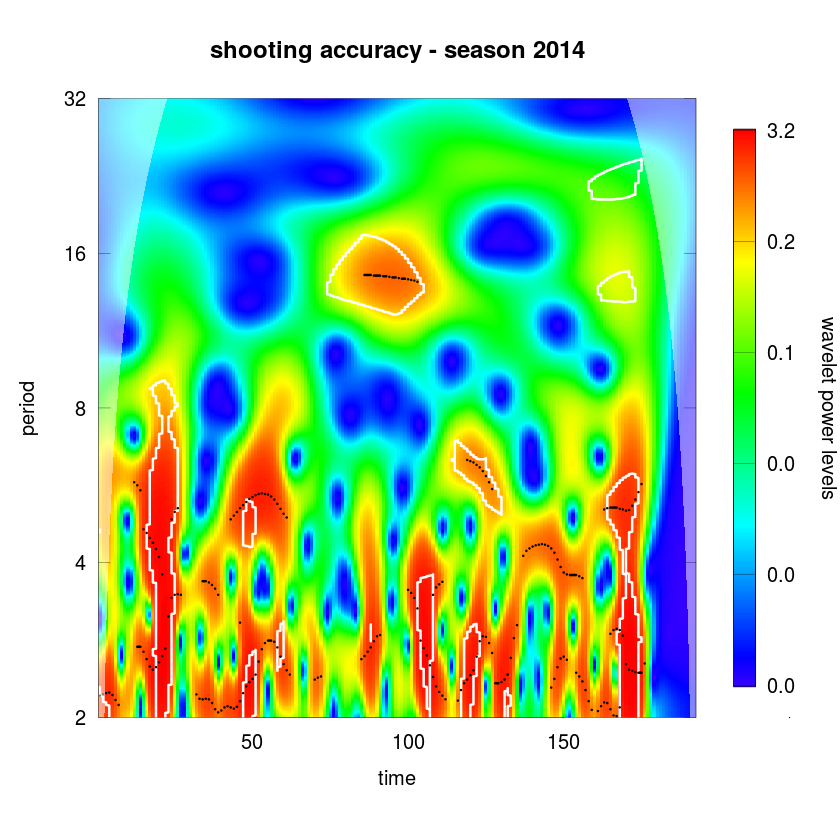

In [54]:
waveletAnalysis(gamesPerDaySum,"FSAC",2014,2,32,"shooting accuracy")

Again a more intermittent picture opens up. We do see a slump around games 75-85, but it looks like an up and down involving mainly periods with timespans between 2 and 6 gamedays.

Starting wavelet transformation...
... and simulations... 
  |======================================================================| 100%
Class attributes are accessible through following names:
series loess.span dt dj Wave Phase Ampl Power Power.avg Power.pval Power.avg.pval Ridge Period Scale nc nr coi.1 coi.2 axis.1 axis.2 


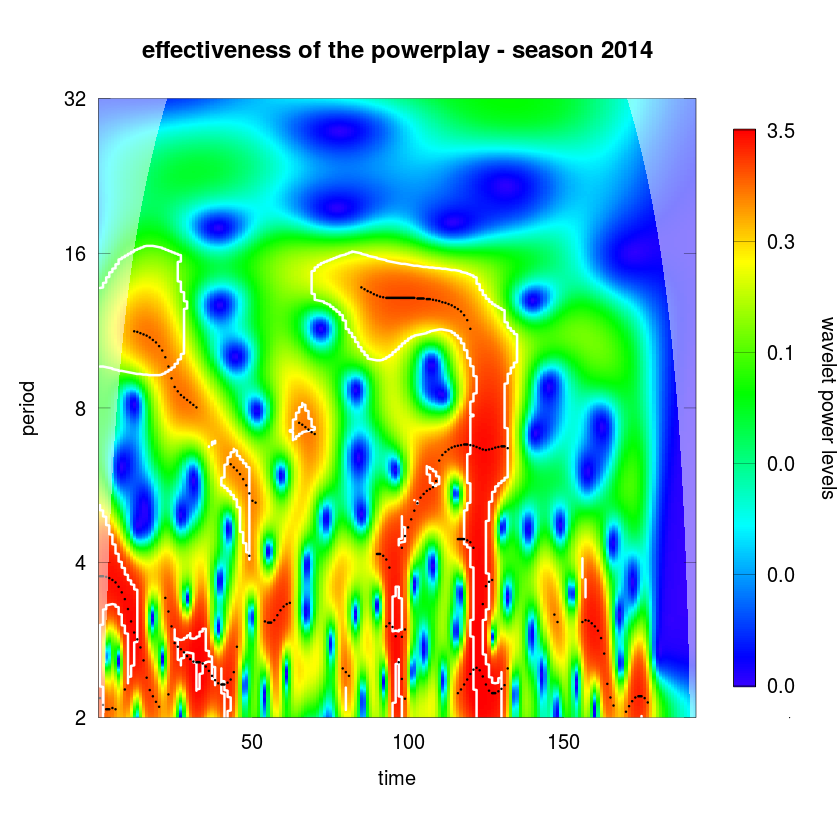

In [55]:
waveletAnalysis(gamesPerDaySum,"FPPLAY",2014,2,32,"effectiveness of the powerplay")

For the effectiveness of the powerplay, means powerplay goals scored per powerplay minute, we have a high ratio at the beginning and around game 100. Again, analyzing the same statistics for 2015 gives another picture.

Starting wavelet transformation...
... and simulations... 
  |======================================================================| 100%
Class attributes are accessible through following names:
series loess.span dt dj Wave Phase Ampl Power Power.avg Power.pval Power.avg.pval Ridge Period Scale nc nr coi.1 coi.2 axis.1 axis.2 


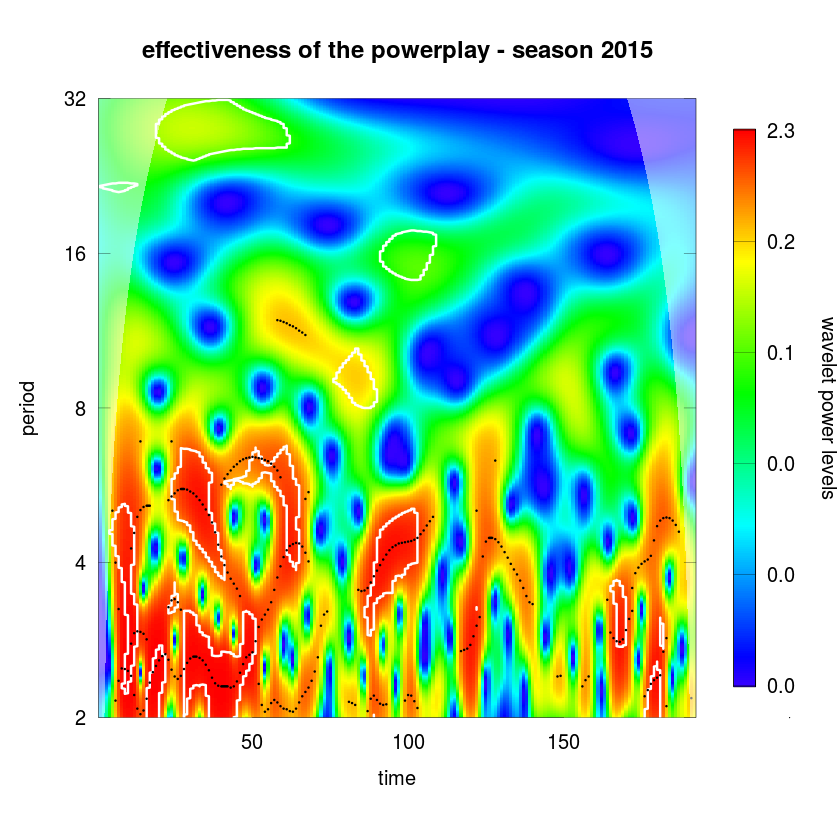

In [56]:
waveletAnalysis(gamesPerDaySum,"FPPLAY",2015,2,32,"effectiveness of the powerplay")

But again, teams headed into a strong season when it comes to taking their chances with one man more on the ice.